<a href="https://colab.research.google.com/github/mohd-faizy/CAREER-TRACK-Data-Scientist-with-Python/blob/main/03_Fine_tuning_your_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 
<strong> 
    <h1 align='center'>Fine Tuning Your Model</h1> 
</strong>

---

Next task is to evaluate its performance. In this notebook, you will learn about some of the other **metrics** available in scikit-learn that will allow us to **assess your model's performance** in a more nuanced manner. Next, learn to optimize your classification and regression models using hyperparameter tuning.

In [1]:
! git clone https://github.com/mohd-faizy/CAREER-TRACK-Data-Scientist-with-Python.git

Cloning into 'CAREER-TRACK-Data-Scientist-with-Python'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2198 (delta 3), reused 2 (delta 0), pack-reused 2186
Receiving objects: 100% (2198/2198), 269.68 MiB | 30.84 MiB/s, done.
Resolving deltas: 100% (781/781), done.
Checking out files: 100% (931/931), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

#plt.style.use('ggplot')
sns.set_theme(style='whitegrid')
%matplotlib inline

In [3]:
os.chdir('/content/CAREER-TRACK-Data-Scientist-with-Python/25_Supervised Learning with scikit-learn/_dataset')
cwd = os.getcwd()
print('Curent working directory is ', cwd)

Curent working directory is  /content/CAREER-TRACK-Data-Scientist-with-Python/25_Supervised Learning with scikit-learn/_dataset


In [4]:
ls

automobile_miles_per_gallon.csv  gm_2008_region.csv
boston_housing.csv               house-votes-84.csv
diabetes.csv                     house-votes-84_missing_data.csv
gapminder_2008_region.csv        PIMA_Indians.csv
gapminder_all.csv                white-wine.csv
gapminder_drop_region.csv        winequality-red.csv


## **How good is your model?**

- **Classification metrics**
    - Measuring model performance with accuracy:
        - Fraction of correctly classified samples
        - Not always a useful metrics

- **Class imbalance example: Emails**

    - **Spam classification**
        - 99% of emails are real; 1% of emails are spam.
        
    - Could build a classifier that predicts ALL emails as real
        - 99% accurate!
        - But horrible at actually classifying spam
        - Fails at its original purpose
- Diagnosing classification predictions
    - ***Confusion matrix***
        ![cm](https://cdn-images-1.medium.com/freeze/max/1000/1*5pDSeiDmya576gP5JfpEpw.png?q=20)
    
    - __Accuracy__:
$$\dfrac{tp + tn}{tp + tn + fp + fn}$$
    
    - __Precision__ (Positive Predictive Value):
$$\dfrac{tp}{tp + fp}$$
    
    - __Recall__ (Sensitivity, hit rate, True Positive Rate):
$$\dfrac{tp}{tp + fn}$$
    
    - __F1 score__: Harmonic mean of precision and recall
$$2\cdot \dfrac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$
    
    - __High precision__ : Not many real emails predicted as spam
    - __High recall__ : Predicted most spam emails correctly


### Metrics for classification
Accuracy is not always an informative metric. In this exercise, you will dive more deeply into evaluating the performance of binary classifiers by computing a confusion matrix and generating a classification report.

You may have noticed in the video that the classification report consisted of three rows, and an additional support column. The support gives the number of samples of the true response that lie in that class - so in the video example, the support was the number of Republicans or Democrats in the test set on which the classification report was computed. The precision, recall, and f1-score columns, then, gave the respective metrics for that particular class.

Here, you'll work with the [PIMA Indians](https://www.kaggle.com/uciml/pima-indians-diabetes-database) dataset obtained from the UCI Machine Learning Repository. The goal is to predict whether or not a given female patient will contract diabetes based on features such as BMI, age, and number of pregnancies. Therefore, it is a binary classification problem. A target value of 0 indicates that the patient does not have diabetes, while a value of 1 indicates that the patient does have diabetes. As in Chapters 1 and 2, the dataset has been preprocessed to deal with missing values.

#### Preprocess

In [5]:
df_diab = pd.read_csv('diabetes.csv')
df_diab.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


```python
# Alternate way of selecting 
# Create arrays for the features and the response variable
y = df_diab['diabetes'].values
X = df_diab.drop('diabetes', axis=1).values
```

In [6]:
X = df_diab.iloc[:, :-1]  # Selecting all except the last column
y = df_diab.iloc[:, -1]   # Selecting the last column

In [7]:
X

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [8]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: diabetes, Length: 768, dtype: int64

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the labels of the test data: y_pred
y_pred = knn.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[176  30]
 [ 56  46]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       206
           1       0.61      0.45      0.52       102

    accuracy                           0.72       308
   macro avg       0.68      0.65      0.66       308
weighted avg       0.71      0.72      0.71       308



## Logistic regression and the ROC curve
- Logistic regression for binary classification
    - Logistic regression outputs probabilities
    - If the probability is greater than 0.5:
        - The data is labeled '1'
    - If the probability is less than 0.5:
        - The data is labeled '0'
- Probability thresholds
    - By default, logistic regression threshold = 0.5
    - Not specific to logistic regression
        - k-NN classifiers also have thresholds
- ROC curves (Receiver Operating Characteristic curve)
![roc](./image/roc.png)

### Building a logistic regression model
Time to build your first logistic regression model! As Hugo showed in the video, scikit-learn makes it very easy to try different models, since the Train-Test-Split/Instantiate/Fit/Predict paradigm applies to all classifiers and regressors - which are known in scikit-learn as 'estimators'. You'll see this now for yourself as you train a logistic regression model on exactly the same data as in the previous exercise. Will it outperform k-NN? There's only one way to find out!

In [10]:
from sklearn.linear_model import LogisticRegression

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[168  38]
 [ 36  66]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       206
           1       0.63      0.65      0.64       102

    accuracy                           0.76       308
   macro avg       0.73      0.73      0.73       308
weighted avg       0.76      0.76      0.76       308



### Plotting an ROC curve
Great job in the previous exercise - you now have a new addition to your toolbox of classifiers!

Classification reports and confusion matrices are great methods to quantitatively evaluate model performance, while ROC curves provide a way to visually evaluate models. As Hugo demonstrated in the video, most classifiers in scikit-learn have a ```.predict_proba()``` method which returns the probability of a given sample being in a particular class. Having built a logistic regression model, you'll now evaluate its performance by plotting an ROC curve. In doing so, you'll make use of the ```.predict_proba()``` method and become familiar with its functionality.

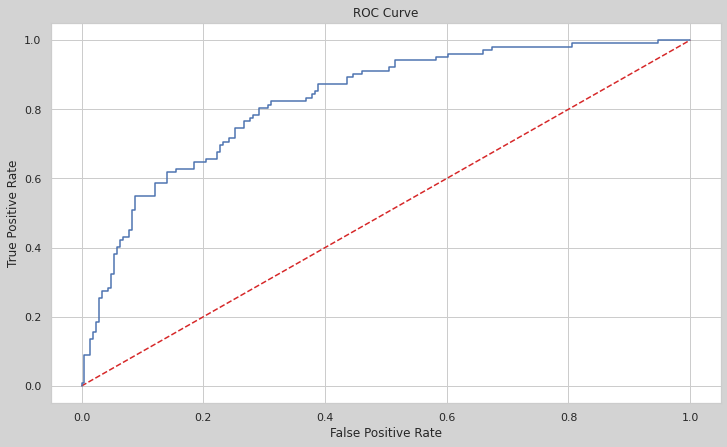

In [11]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(12,7), facecolor='lightgrey')
plt.plot([0, 1], [0, 1], linestyle='--', color='tab:red')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Precision-recall Curve
When looking at your ROC curve, you may have noticed that the y-axis (True positive rate) is also known as recall. Indeed, in addition to the ROC curve, there are other ways to visually evaluate model performance. One such way is the precision-recall curve, which is generated by plotting the precision and recall for different thresholds. As a reminder, precision and recall are defined as:
$$ \text{Precision} = \dfrac{TP}{TP + FP} \\
   \text{Recall} = \dfrac{TP}{TP + FN}$$
   Study the precision-recall curve. Note that here, the class is positive (1) if the individual has diabetes.

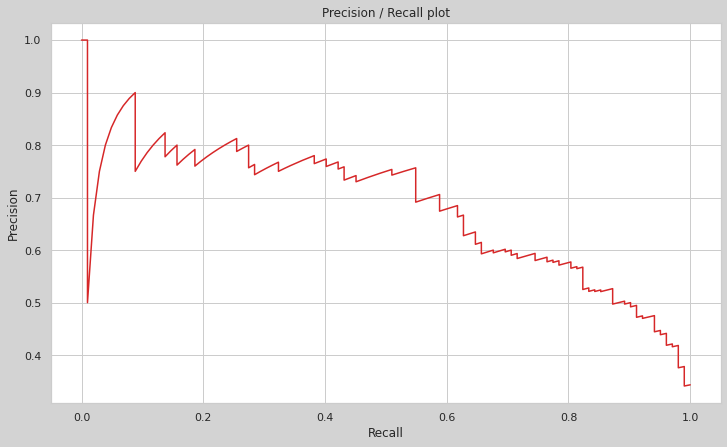

In [12]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(12,7), facecolor='lightgrey')
plt.plot(recall, precision, color='tab:red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision / Recall plot')
plt.show()

## Area under the ROC curve (AUC)
- Larger area under the ROC curve = better model

### AUC computation
Say you have a binary classifier that in fact is just randomly making guesses. It would be correct approximately 50% of the time, and the resulting ROC curve would be a diagonal line in which the True Positive Rate and False Positive Rate are always equal. The Area under this ROC curve would be 0.5. This is one way in which the AUC, which Hugo discussed in the video, is an informative metric to evaluate a model. If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!

In this exercise, you'll calculate AUC scores using the ```roc_auc_score()``` function from ```sklearn.metrics``` as well as by performing cross-validation on the diabetes dataset.

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilites: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.8242908814011042
AUC scores computed using 5-fold cross-validation: [0.81222222 0.80777778 0.82574074 0.87283019 0.84490566]


## Hyperparameter tuning
- Linear regression: Choosing parameters
- Ridge/Lasso regression: Choosing alpha
- k-Nearest Neighbors: Choosing n_neighbors
- Hyperparameters: Parameters like alpha and k
- Hyperparameters cannot be learned by fitting the model
- Choosing the correct hyperparameter
    - Try a bunch of different hyperparameter values
    - Fit all of them separately
    - See how well each performs
    - Choose the best performing one
    - It is essential to use cross-validation
- Grid search cross-validation

### Hyperparameter tuning with GridSearchCV
Like the alpha parameter of lasso and ridge regularization that you saw earlier, logistic regression also has a regularization parameter: $C$. $C$ controls the inverse of the regularization strength, and this is what you will tune in this exercise. A large $C$ can lead to an overfit model, while a small $C$ can lead to an underfit model.

The hyperparameter space for $C$ has been setup for you. Your job is to use GridSearchCV and logistic regression to find the optimal $C$ in this hyperparameter space. 

You may be wondering why you aren't asked to split the data into training and test sets. Good observation! Here, we want you to focus on the process of setting up the hyperparameter grid and performing grid-search cross-validation. In practice, you will indeed want to hold out a portion of your data for evaluation purposes, and you will learn all about this in the next video!

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.006105402296585327}
Best score is 0.7734742381801205


### Hyperparameter tuning with RandomizedSearchCV
GridSearchCV can be computationally expensive, especially if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. A solution to this is to use ```RandomizedSearchCV```, in which not all hyperparameter values are tried out. Instead, a fixed number of hyperparameter settings is sampled from specified probability distributions. You'll practice using ```RandomizedSearchCV``` in this exercise and see how this works.

Here, you'll also be introduced to a new model: the Decision Tree. Don't worry about the specifics of how this model works. Just like k-NN, linear regression, and logistic regression, decision trees in scikit-learn have ```.fit()``` and ```.predict()``` methods that you can use in exactly the same way as before. Decision trees have many parameters that can be tuned, such as ```max_features```, ```max_depth```, and ```min_samples_leaf```: This makes it an ideal use case for ```RandomizedSearchCV```.

In [15]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 9),
    "min_samples_leaf": randint(1, 9),
    "criterion": ["gini", "entropy"],
}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 4}
Best score is 0.7448688566335624


## Hold-out set for final evaluation
- How well can the model perform on never before seen data?
- Using ALL data for cross-validation is not ideal
- Split data into training and hold-out set at the beginning
- Perform grid search cross-validation on training set
- Choose best hyperparameters and evaluate on hold-out set

### Hold-out set in practice I: Classification
You will now practice evaluating a model with tuned hyperparameters on a hold-out set. The feature array and target variable array from the diabetes dataset have been pre-loaded as ```X``` and ```y```.

In addition to $C$, logistic regression has a ```'penalty'``` hyperparameter which specifies whether to use ```'l1'``` or ```'l2'``` regularization. Your job in this exercise is to create a hold-out set, tune the ```'C'``` and ```'penalty'``` hyperparameters of a logistic regression classifier using ```GridSearchCV``` on the training set.

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Create the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 3.727593720314938, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.7608695652173914


### Hold-out set in practice II: Regression
Remember lasso and ridge regression from the previous chapter? Lasso used the $L1$ penalty to regularize, while ridge used the $L2$ penalty. There is another type of regularized regression known as the elastic net. In elastic net regularization, the penalty term is a linear combination of the $L1$ and $L2$ penalties:
$$ a * L1 + b * L2 $$

In scikit-learn, this term is represented by the ```'l1_ratio'``` parameter: An ```'l1_ratio'``` of 1 corresponds to an $L1$ penalty, and anything lower is a combination of $L1$ and $L2$.

In this exercise, you will ```GridSearchCV``` to tune the ```'l1_ratio'``` of an elastic net model trained on the Gapminder data. As in the previous exercise, use a hold-out set to evaluate your model's performance.

#### Preprocess

In [17]:
df_gm = pd.read_csv('gm_2008_region.csv')
df_gm.drop(labels=['Region'], axis='columns', inplace=True)
df_gm.head()

,population,fertility,HIV,CO2,BMI_male,GDP,BMI_female,life,child_mortality
0,34811059.0,2.73,0.1,3.328945,24.59620,12314.0,129.9049,75.3,29.5
1,19842251.0,6.43,2.0,1.474353,22.25083,7103.0,130.1247,58.3,192.0
2,40381860.0,2.24,0.5,4.785170,27.50170,14646.0,118.8915,75.5,15.4
3,2975029.0,1.40,0.1,1.804106,25.35542,7383.0,132.8108,72.5,20.0
4,21370348.0,1.96,0.1,18.016313,27.56373,41312.0,117.3755,81.5,5.2


In [18]:
X = df_gm.drop('life', axis='columns').values
y = df_gm['life'].values

In [19]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(max_iter=100000, tol=0.001)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_pred,y_test)

print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282.48621758501486, tolerance: 5.58941590909091
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309.84663914864217, tolerance: 5.893071666666668
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 255.50344008058215, tolerance: 5.890250303030303
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 287.672841

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.20689655172413793}
Tuned ElasticNet R squared: 0.8668305372460283
Tuned ElasticNet MSE: 10.057914133398445
